# Locate People and Objects

This notebook is part of [Lab 3](https://github.com/ee292d/labs/blob/main/lab3/README.md), which focuses on locating objects within an image, for the [EE292D Edge ML class](https://ee292d.github.io/) at Stanford. It shows how to download some pretrained models for person and object detection.

If you're not already in Google's Colab environment (or another notebook client) [click here to open it in Colab](https://colab.research.google.com/github/ee292d/labs/blob/main/lab3/notebook.ipynb).

## Install Ultralytics

We used [Ultralytics](https://github.com/ultralytics/ultralytics) for [Lab 2](https://github.com/ee292d/labs/blob/main/lab2/README.md), and since the project also offers some very efficient models for finding where objects are in a scene, we'll install it in this notebook too.

In [1]:
%pip install ultralytics==8.1.47

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.42 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 28.9/201.2 GB disk)


## Download and Run a Detection Model

In computer vision, the task of finding the locations of objects in a scene is known as "detection", which is different than the "classification" of images that we performed in the previous lab.

To understand the difference, "*Does this image contain a hot dog?*" is a classification question, but "*Does this image contain any hot dogs, and where are they?*" is detection. As you might imagine, detection is a harder task than classification, and understanding the output of the model is also more complicated.

Thankfully the Ultralytics team have created some classification models that offer good tradeoffs between accuracy and latency. We'll download one of them and run it on a test image.

In [2]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
results = model('https://ultralytics.com/images/bus.jpg')
print(results[0].boxes)

100%|██████████| 6.23M/6.23M [00:00<00:00, 23.6MB/s]


100%|██████████| 476k/476k [00:00<00:00, 3.70MB/s]


image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 116.9ms
Speed: 15.8ms preprocess, 116.9ms inference, 817.0ms postprocess per image at shape (1, 3, 640, 480)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([ 5.,  0.,  0.,  0., 11.,  0.], device='cuda:0')
conf: tensor([0.8705, 0.8690, 0.8536, 0.8193, 0.3461, 0.3013], device='cuda:0')
data: tensor([[1.7286e+01, 2.3059e+02, 8.0152e+02, 7.6841e+02, 8.7054e-01, 5.0000e+00],
        [4.8739e+01, 3.9926e+02, 2.4450e+02, 9.0250e+02, 8.6898e-01, 0.0000e+00],
        [6.7027e+02, 3.8028e+02, 8.0986e+02, 8.7569e+02, 8.5360e-01, 0.0000e+00],
        [2.2139e+02, 4.0579e+02, 3.4472e+02, 8.5739e+02, 8.1931e-01, 0.0000e+00],
        [6.4347e-02, 2.5464e+02, 3.2288e+01, 3.2504e+02, 3.4607e-01, 1.1000e+01],
        [0.0000e+00, 5.5101e+02, 6.7105e+01, 8.7394e+02, 3.0129e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1080, 810)
shape: torch.Size([6, 6])
xywh: tensor([[409.4020, 499.4990,

This gives us the numerical information about the object names, scores, and locations, but it's not easy to make sense in this form. To help, we can plot the results on the original image.

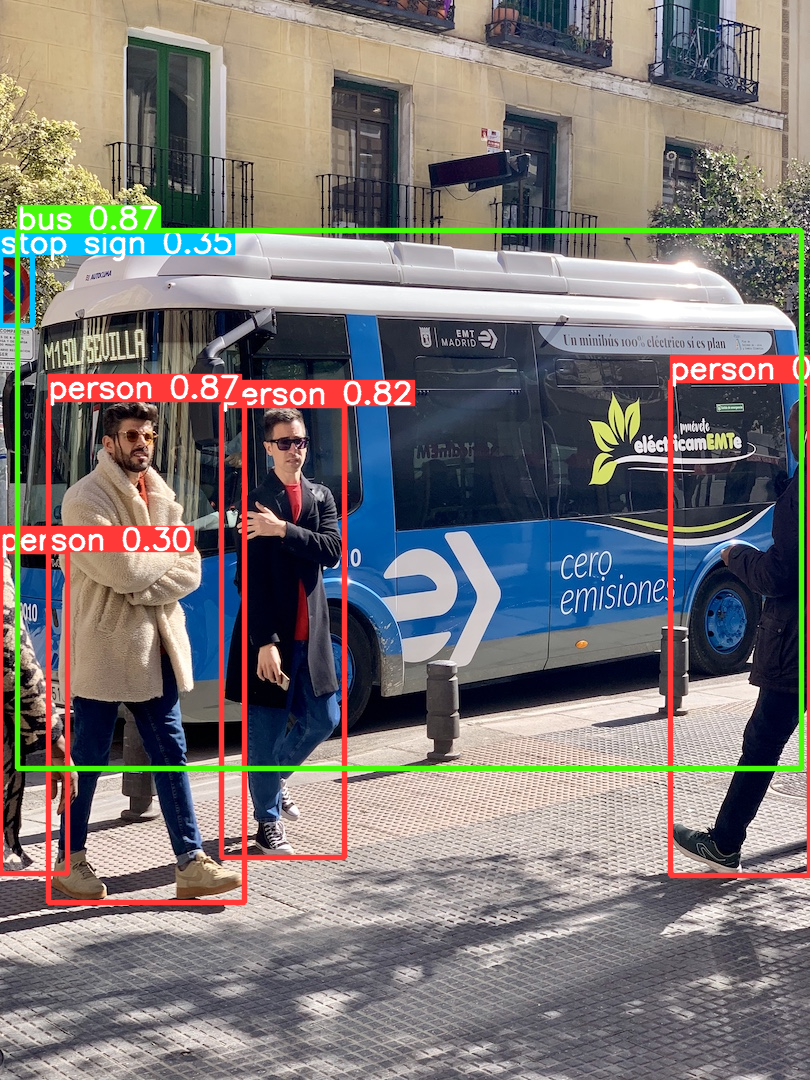

In [3]:
from PIL import Image as im

# We need to switch from BGR to RGB channel order.
bgr_array = results[0].plot()
rgb_array = bgr_array[:, :, ::-1]

im.fromarray(rgb_array)

## Exporting to TensorFlow Lite

We want to run this model as fast as possible on our Raspberry Pi, and TensorFlow Lite offers an efficient inference framework designed for phones and boards like the Pi. We do need to export it from the Ultralytics format into a file TF Lite can understand though. As with the classification notebook, we'll do this by running Ultralytics export function targeting TF Lite and 8-bit quantization. The process can take several minutes, and you can expect to see a `StatusCode` error at the end, but that shouldn't affect the overall output since it happens after the files we need are saved.

One important argument is `imgsz`, which defines the width and height of the input images. The default for YOLOv8 is 640x640 pixels, which results in a model that takes nearly 400 milliseconds to run! By reducing the input size to 224x224 pixels, the latency shrinks to around 25 milliseconds, without much loss of accuracy.

In [6]:
model.export(format='tflite', imgsz=224, int8=True)

Ultralytics YOLOv8.1.42 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 84, 1029) (6.2 MB)

TensorFlow SavedModel: starting export with tensorflow 2.15.0...
WARNING ⚠️ tensorflow<=2.13.1 is required, but tensorflow==2.15.0 is currently installed https://github.com/ultralytics/ultralytics/issues/5161

ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: simplifying with onnxsim 0.4.36...
ONNX: export success ✅ 1.4s, saved as 'yolov8n.onnx' (12.1 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.17.5...

Automatic generation of each OP name started ========================================
Automatic generation of each OP name complete!

Model loaded ========================================================================

Model conversion started ============================================================
saved_model output started ===========================

ImportError: generic_type: cannot initialize type "StatusCode": an object with that name is already defined

## Download the Model

After the export has been run, you'll need to find the output file. To do this, open the file explorer from the icon on the left side of the notebook, and navigate to the `yolov8n_saved_model` folder. In there you should see a `yolov8n_int8.tflite` file. Right click on it and select "Download" to save it to your laptop.

Once that's complete, drag it to the `models` folder in your VS Code editor, and then return to the [Lab 3 instructions](https://github.com/ee292d/labs/tree/main/lab3#locate-people-and-objects)
to run it on your board. You'll continue this notebook once you've given that a try.

## Train a Custom Model

Most applications are likely to need a model that can recognize more than the standard 80 kinds of objects that COCO supports by default. To enable this, you'll first need to gather your own dataset of images with ground truth labels for the objects and their locations. You'll also need to make sure that the dataset is in the [Ultralytics YOLO format](https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format).

To show you how this works, I'm going to use a pre-built dataset of different African wildlife, but you should be able to use the same approach with your own dataset once you have one. You'll have to create your own YAML file with the labels, and ensure there's a .txt file with box information for every image, but hopefully you should be able to see from the documentation and the layout here what you need to do.

In [8]:
!mkdir -p datasets
!wget -q -O datasets/african-wildlife.zip https://ultralytics.com/assets/african-wildlife.zip
!unzip -qq -o datasets/african-wildlife.zip -d datasets/african-wildlife
!wget -q -O datasets/african-wildlife.yaml https://github.com/ultralytics/ultralytics/raw/main/ultralytics/cfg/datasets/african-wildlife.yaml

The training itself will take around ten minutes to complete.

In [9]:
train_results = model.train(data="datasets/african-wildlife.yaml", imgsz=224, pretrained=True, freeze=9, epochs=100)
save_dir = train_results.save_dir

Ultralytics YOLOv8.1.42 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets/african-wildlife.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=9, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

100%|██████████| 755k/755k [00:00<00:00, 4.81MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               


  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /content/datasets/african-wildlife/train/labels... 1052 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1052/1052 [00:00<00:00, 1225.66it/s]

train: New cache created: /content/datasets/african-wildlife/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/african-wildlife/valid/labels... 225 images, 0 backgrounds, 0 corrupt: 100%|██████████| 225/225 [00:00<00:00, 1122.13it/s]

val: New cache created: /content/datasets/african-wildlife/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.742G      2.492      3.346      2.185         49        224: 100%|██████████| 66/66 [00:08<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.16it/s]


                   all        225        379      0.279      0.207      0.201      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.742G      1.813      2.262      1.676         62        224: 100%|██████████| 66/66 [00:05<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.74it/s]

                   all        225        379      0.425      0.472      0.432      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.747G      1.583      1.911      1.526         51        224: 100%|██████████| 66/66 [00:04<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.63it/s]

                   all        225        379      0.498      0.513      0.511       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.747G      1.413      1.761      1.431         44        224: 100%|██████████| 66/66 [00:05<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

                   all        225        379      0.575      0.502      0.562      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.744G      1.341      1.633      1.375         44        224: 100%|██████████| 66/66 [00:04<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.38it/s]

                   all        225        379      0.649      0.527      0.623      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.747G      1.313      1.556      1.342         53        224: 100%|██████████| 66/66 [00:04<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.78it/s]

                   all        225        379      0.645      0.573      0.656      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.747G      1.293      1.531      1.338         41        224: 100%|██████████| 66/66 [00:04<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.19it/s]


                   all        225        379      0.719       0.57      0.668       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.747G      1.257      1.457      1.307         51        224: 100%|██████████| 66/66 [00:04<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.67it/s]

                   all        225        379      0.753      0.588      0.714      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.747G      1.228      1.432      1.286         47        224: 100%|██████████| 66/66 [00:04<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.66it/s]

                   all        225        379      0.798      0.616      0.746      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.744G      1.246      1.385      1.284         55        224: 100%|██████████| 66/66 [00:04<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.78it/s]

                   all        225        379      0.789      0.637       0.76      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.744G      1.222      1.366      1.269         56        224: 100%|██████████| 66/66 [00:04<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.68it/s]

                   all        225        379      0.678      0.658      0.716      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.744G      1.185       1.35      1.246         47        224: 100%|██████████| 66/66 [00:04<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.02it/s]

                   all        225        379      0.709      0.711      0.763      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.744G      1.172      1.307      1.241         51        224: 100%|██████████| 66/66 [00:05<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.00it/s]

                   all        225        379      0.704      0.737       0.77      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.744G      1.188      1.315      1.241         49        224: 100%|██████████| 66/66 [00:04<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.03it/s]

                   all        225        379      0.729      0.687      0.756      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.744G      1.178      1.297      1.244         52        224: 100%|██████████| 66/66 [00:05<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.12it/s]

                   all        225        379      0.801      0.677      0.787      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.744G      1.133      1.257      1.221         47        224: 100%|██████████| 66/66 [00:04<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.93it/s]

                   all        225        379      0.714      0.728      0.786      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.744G      1.157      1.244      1.232         59        224: 100%|██████████| 66/66 [00:05<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.77it/s]

                   all        225        379      0.788      0.677      0.786      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.744G      1.145      1.269      1.222         50        224: 100%|██████████| 66/66 [00:04<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.87it/s]

                   all        225        379       0.83      0.691      0.807       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.744G      1.154      1.215      1.219         57        224: 100%|██████████| 66/66 [00:05<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.84it/s]

                   all        225        379      0.764      0.727      0.806      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.744G      1.153       1.24      1.218         57        224: 100%|██████████| 66/66 [00:04<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.96it/s]

                   all        225        379      0.781      0.753      0.823      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.744G      1.136      1.205       1.21         52        224: 100%|██████████| 66/66 [00:04<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.02it/s]

                   all        225        379      0.747      0.735       0.81      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.744G      1.142      1.209      1.222         44        224: 100%|██████████| 66/66 [00:04<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.09it/s]

                   all        225        379       0.82       0.72      0.813       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.744G      1.113      1.179      1.195         72        224: 100%|██████████| 66/66 [00:05<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]

                   all        225        379       0.84      0.721      0.819      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.744G      1.106      1.159      1.197         39        224: 100%|██████████| 66/66 [00:04<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]

                   all        225        379       0.84      0.708      0.829      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.744G      1.114      1.161      1.198         48        224: 100%|██████████| 66/66 [00:05<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.96it/s]

                   all        225        379      0.773      0.739      0.819      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.744G      1.111      1.173        1.2         41        224: 100%|██████████| 66/66 [00:04<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.83it/s]

                   all        225        379      0.828      0.726      0.833       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.744G      1.113      1.164      1.192         55        224: 100%|██████████| 66/66 [00:05<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.82it/s]

                   all        225        379      0.854      0.728      0.832      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.744G      1.095      1.147      1.176         42        224: 100%|██████████| 66/66 [00:04<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]

                   all        225        379      0.802      0.722       0.82      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.744G      1.072      1.111      1.183         34        224: 100%|██████████| 66/66 [00:05<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.89it/s]

                   all        225        379      0.824      0.739      0.838      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.747G       1.09      1.115      1.179         60        224: 100%|██████████| 66/66 [00:04<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.64it/s]

                   all        225        379      0.795      0.745      0.823      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.744G      1.061      1.108      1.172         37        224: 100%|██████████| 66/66 [00:04<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.05it/s]

                   all        225        379      0.844      0.726      0.832      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.744G      1.083      1.097      1.175         53        224: 100%|██████████| 66/66 [00:04<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.32it/s]

                   all        225        379      0.845      0.717      0.841       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.744G      1.103      1.103      1.175         47        224: 100%|██████████| 66/66 [00:04<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.05it/s]

                   all        225        379      0.855      0.725      0.828      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.744G      1.049      1.083      1.156         67        224: 100%|██████████| 66/66 [00:04<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.10it/s]

                   all        225        379      0.807      0.771      0.843      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.744G      1.077       1.08      1.171         72        224: 100%|██████████| 66/66 [00:04<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.25it/s]

                   all        225        379      0.838      0.758      0.846      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.744G      1.075      1.087       1.17         59        224: 100%|██████████| 66/66 [00:04<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.09it/s]

                   all        225        379      0.815      0.708       0.81      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.744G      1.064      1.079      1.162         49        224: 100%|██████████| 66/66 [00:04<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.92it/s]

                   all        225        379      0.852      0.745      0.831      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.744G      1.071      1.076      1.171         62        224: 100%|██████████| 66/66 [00:05<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.92it/s]

                   all        225        379      0.846      0.714      0.835      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.744G       1.08      1.083      1.171         64        224: 100%|██████████| 66/66 [00:04<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.65it/s]

                   all        225        379      0.839      0.744      0.852      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.744G      1.086      1.048      1.164         50        224: 100%|██████████| 66/66 [00:04<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.75it/s]

                   all        225        379      0.848      0.718      0.841      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.744G      1.059      1.065      1.162         61        224: 100%|██████████| 66/66 [00:04<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.07it/s]

                   all        225        379      0.848      0.736      0.849      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.744G      1.017      1.006      1.138         40        224: 100%|██████████| 66/66 [00:05<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.81it/s]

                   all        225        379      0.803      0.771      0.845      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.744G      1.054       1.04      1.157         61        224: 100%|██████████| 66/66 [00:04<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.91it/s]

                   all        225        379      0.883      0.708      0.847      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.744G      1.021      1.027      1.144         72        224: 100%|██████████| 66/66 [00:04<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.88it/s]

                   all        225        379      0.804      0.751      0.838      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.744G      1.044      1.018      1.148         45        224: 100%|██████████| 66/66 [00:04<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.21it/s]

                   all        225        379      0.854      0.731      0.848      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.744G      1.039      1.019       1.14         55        224: 100%|██████████| 66/66 [00:04<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.12it/s]

                   all        225        379      0.838      0.753      0.855      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.744G      1.016     0.9896       1.14         56        224: 100%|██████████| 66/66 [00:04<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.20it/s]

                   all        225        379      0.853      0.753      0.858      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.744G      1.018     0.9803      1.141         44        224: 100%|██████████| 66/66 [00:04<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]

                   all        225        379      0.785      0.771       0.85      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.744G      1.037      1.017      1.143         79        224: 100%|██████████| 66/66 [00:04<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.05it/s]

                   all        225        379      0.848      0.748      0.861      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.744G      1.036       1.01      1.147         37        224: 100%|██████████| 66/66 [00:05<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.04it/s]

                   all        225        379      0.822      0.776      0.858      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.744G      1.006     0.9836      1.136         45        224: 100%|██████████| 66/66 [00:04<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.07it/s]

                   all        225        379      0.803      0.743      0.853      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.744G      1.034     0.9927      1.142         41        224: 100%|██████████| 66/66 [00:04<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.81it/s]

                   all        225        379      0.781      0.788      0.851      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.744G      1.028     0.9901      1.131         46        224: 100%|██████████| 66/66 [00:04<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.94it/s]

                   all        225        379      0.827      0.746      0.858      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.744G      1.018      1.002      1.128         46        224: 100%|██████████| 66/66 [00:04<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.61it/s]

                   all        225        379      0.814      0.763      0.854      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.744G      1.031     0.9865      1.131         43        224: 100%|██████████| 66/66 [00:04<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]

                   all        225        379       0.87      0.755      0.868      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.744G     0.9963     0.9693       1.12         55        224: 100%|██████████| 66/66 [00:04<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.67it/s]

                   all        225        379      0.824      0.773      0.839       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.744G      1.001     0.9647      1.138         43        224: 100%|██████████| 66/66 [00:04<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]

                   all        225        379      0.872      0.725      0.854      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.744G      1.018     0.9805      1.133         45        224: 100%|██████████| 66/66 [00:04<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.90it/s]

                   all        225        379      0.857      0.769      0.858      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.744G     0.9931     0.9523      1.112         51        224: 100%|██████████| 66/66 [00:04<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.35it/s]

                   all        225        379      0.862      0.766      0.866      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.744G     0.9988      0.949      1.118         46        224: 100%|██████████| 66/66 [00:04<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.09it/s]

                   all        225        379      0.813      0.779       0.86      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.744G      1.016     0.9443      1.126         57        224: 100%|██████████| 66/66 [00:05<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.57it/s]

                   all        225        379      0.907      0.728      0.864      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.744G      1.009      0.962       1.13         40        224: 100%|██████████| 66/66 [00:04<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.11it/s]

                   all        225        379      0.833      0.791      0.868      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.744G     0.9978     0.9504      1.123         57        224: 100%|██████████| 66/66 [00:05<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.18it/s]

                   all        225        379      0.826      0.769      0.853      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.744G     0.9851     0.9348      1.113         27        224: 100%|██████████| 66/66 [00:05<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.13it/s]

                   all        225        379      0.845      0.741      0.855      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.742G     0.9956     0.9601       1.12         57        224: 100%|██████████| 66/66 [00:05<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.67it/s]

                   all        225        379      0.839      0.795       0.87      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.744G     0.9847     0.9285      1.117         43        224: 100%|██████████| 66/66 [00:05<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.37it/s]


                   all        225        379      0.823      0.772      0.853      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.744G     0.9942     0.9341      1.116         53        224: 100%|██████████| 66/66 [00:05<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.81it/s]

                   all        225        379      0.818      0.803      0.871      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.744G     0.9914     0.9468      1.119         47        224: 100%|██████████| 66/66 [00:04<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.68it/s]

                   all        225        379      0.823      0.796      0.868      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.744G     0.9905     0.9232       1.12         44        224: 100%|██████████| 66/66 [00:05<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.86it/s]

                   all        225        379      0.844      0.769      0.861      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.744G     0.9804     0.9286      1.117         45        224: 100%|██████████| 66/66 [00:04<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.83it/s]

                   all        225        379      0.879      0.753      0.872      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.744G     0.9746     0.9251      1.101         49        224: 100%|██████████| 66/66 [00:05<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.94it/s]

                   all        225        379       0.86      0.767       0.87      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.744G      0.986      0.906      1.115         38        224: 100%|██████████| 66/66 [00:04<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.46it/s]

                   all        225        379      0.869      0.776      0.876      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.744G     0.9597     0.9066      1.101         59        224: 100%|██████████| 66/66 [00:04<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.71it/s]

                   all        225        379      0.851       0.76      0.867      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.744G     0.9808     0.9227      1.112         38        224: 100%|██████████| 66/66 [00:05<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]

                   all        225        379      0.881      0.757      0.866      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.744G     0.9846      0.926      1.114         45        224: 100%|██████████| 66/66 [00:04<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.78it/s]

                   all        225        379      0.901      0.752      0.875      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.744G     0.9723     0.9107      1.109         60        224: 100%|██████████| 66/66 [00:05<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.39it/s]

                   all        225        379      0.899      0.753      0.875      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.744G      0.963     0.8934      1.104         51        224: 100%|██████████| 66/66 [00:05<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.81it/s]

                   all        225        379      0.911      0.728      0.874      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.744G     0.9745     0.9049      1.102         49        224: 100%|██████████| 66/66 [00:05<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]

                   all        225        379      0.889      0.766      0.872      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.744G     0.9747     0.9104      1.114         52        224: 100%|██████████| 66/66 [00:05<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]

                   all        225        379      0.825      0.813      0.871      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.744G     0.9798     0.9101      1.102         49        224: 100%|██████████| 66/66 [00:05<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.05it/s]

                   all        225        379      0.895      0.764      0.872      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.744G     0.9603     0.8961      1.105         45        224: 100%|██████████| 66/66 [00:05<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.10it/s]

                   all        225        379      0.885      0.798      0.883      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.744G     0.9669     0.9056      1.096         42        224: 100%|██████████| 66/66 [00:05<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.01it/s]

                   all        225        379      0.869      0.778      0.874      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.744G     0.9576     0.8908      1.102         49        224: 100%|██████████| 66/66 [00:04<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.04it/s]

                   all        225        379      0.809      0.824      0.876      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.744G     0.9609     0.8996      1.106         44        224: 100%|██████████| 66/66 [00:05<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.77it/s]

                   all        225        379      0.912      0.748      0.876      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.744G     0.9846      0.895      1.107         56        224: 100%|██████████| 66/66 [00:04<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.02it/s]

                   all        225        379      0.846      0.799      0.879      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.744G     0.9513     0.8856      1.095         54        224: 100%|██████████| 66/66 [00:05<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.71it/s]

                   all        225        379      0.878      0.784      0.878      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.744G      1.004     0.9224      1.126         55        224: 100%|██████████| 66/66 [00:04<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.09it/s]

                   all        225        379      0.876      0.782      0.877      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.744G     0.9508     0.8891      1.089         56        224: 100%|██████████| 66/66 [00:05<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        225        379      0.883      0.775      0.878      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.744G     0.9435     0.8735      1.094         53        224: 100%|██████████| 66/66 [00:05<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

                   all        225        379      0.898      0.773      0.881      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.744G     0.9844     0.9036      1.108         60        224: 100%|██████████| 66/66 [00:04<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.04it/s]

                   all        225        379      0.879       0.78      0.879      0.674


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.744G      0.895     0.7895      1.028         18        224: 100%|██████████| 66/66 [00:06<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.79it/s]

                   all        225        379      0.874      0.748      0.848      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.742G     0.8559     0.7234      1.017         28        224: 100%|██████████| 66/66 [00:04<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.74it/s]

                   all        225        379      0.866      0.753      0.854       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.744G     0.8598     0.7167      1.025         17        224: 100%|██████████| 66/66 [00:05<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.96it/s]

                   all        225        379      0.867      0.762      0.855      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.744G     0.8359      0.704      1.003         24        224: 100%|██████████| 66/66 [00:04<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.11it/s]

                   all        225        379        0.9      0.751      0.857      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.742G     0.8524     0.6986      1.022         20        224: 100%|██████████| 66/66 [00:04<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.94it/s]

                   all        225        379        0.9      0.744      0.859      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.742G     0.8366     0.6845      1.009         18        224: 100%|██████████| 66/66 [00:04<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]

                   all        225        379      0.886      0.753      0.858      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.744G     0.8441     0.6742      1.009         21        224: 100%|██████████| 66/66 [00:05<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.00it/s]

                   all        225        379      0.891      0.754      0.858      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.744G     0.8454     0.6978       1.01         29        224: 100%|██████████| 66/66 [00:04<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.81it/s]

                   all        225        379       0.86      0.778      0.859      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.744G     0.8346      0.682      1.008         23        224: 100%|██████████| 66/66 [00:05<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]

                   all        225        379      0.886       0.75      0.857      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.744G      0.842     0.6806       1.01         19        224: 100%|██████████| 66/66 [00:04<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.78it/s]

                   all        225        379      0.881      0.758      0.856      0.656



100 epochs completed in 0.174 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.42 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


                   all        225        379      0.899      0.772      0.881      0.679
               buffalo        225         89      0.884      0.774      0.897      0.737
              elephant        225         91       0.85      0.791      0.849      0.651
                 rhino        225         85       0.95      0.812      0.928      0.733
                 zebra        225        114       0.91      0.712      0.851      0.593
Speed: 0.0ms preprocess, 5.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/train


With the training complete, we can now run the model on an example image to make sure it's working reasonably well.

100%|██████████| 36.7k/36.7k [00:00<00:00, 3.32MB/s]

image 1/1 /content/zebra.jpeg: 224x224 5 zebras, 9.9ms
Speed: 0.6ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 224)


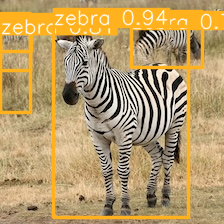

In [10]:
african_model = YOLO(str(save_dir) + "/weights/best.pt")
results = african_model('https://raw.githubusercontent.com/ee292d/labs/main/images/zebra.jpeg')

bgr_array = results[0].plot()
rgb_array = bgr_array[:, :, ::-1]
im.fromarray(rgb_array)

## Export the Custom Model

Now that we've verified the model is working as expected, we'll save it as a TensorFlow Lite file that we can run on the Pi.

In [11]:
african_model.export(format='tflite', imgsz=224, int8=True)

Ultralytics YOLOv8.1.42 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 8, 1029) (5.9 MB)

TensorFlow SavedModel: starting export with tensorflow 2.15.0...
WARNING ⚠️ tensorflow<=2.13.1 is required, but tensorflow==2.15.0 is currently installed https://github.com/ultralytics/ultralytics/issues/5161

ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: simplifying with onnxsim 0.4.36...
ONNX: export success ✅ 1.1s, saved as 'runs/detect/train/weights/best.onnx' (11.6 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.17.5...

Automatic generation of each OP name started ========================================
Automatic generation of each OP name complete!

Model loaded ========================================================================

Model conversion started ============================================================
saved_mod

ImportError: generic_type: cannot initialize type "StatusCode": an object with that name is already defined

## Download the Custom Model

You'll need to locate the `best_int8.tflite` model in the file explorer to the left, and right-click on the it to download it to your laptop. Finding it can be a bit tricky, since it will be saved in the `runs/detect/<latest run>/weights/best_saved_model` folder, where "latest run" is the most recent folder at that level. Here's an example where my latest run was "train":



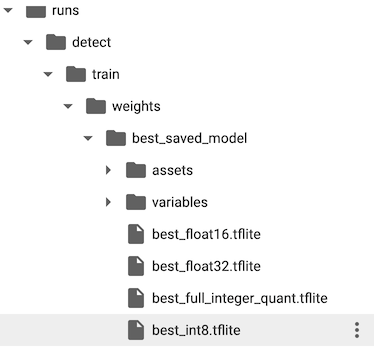

You can now rename this file to `african_wildlife.tflite` and copy it to the Pi to run it, like you did with the standard model. You'll find instructions to test the model on the Pi in the lab 3 readme.